In [69]:
import os
import pandas as pd
import numpy as np

# #Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Default Size plot 
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12

#Handle warning
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

#nltk preprocessing modules
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

#regex to find the pattern
import re

#display pandas dataframe columns 
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

In [70]:
df1 = pd.read_csv(r'/Users/hirthickkesh/Downloads/hate_tweet/train.csv', delimiter=',',engine='python',encoding='utf-8-sig')
test = pd.read_csv(r'/Users/hirthickkesh/Downloads/hate_tweet/test.csv')

In [71]:
df1.drop('id',axis=1,inplace=True)

In [72]:
import unicodedata
def simplify(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [73]:
df1['tweet'] = df1['tweet'].apply(simplify)
df1['tweet'].replace(r'@\w+','',regex=True,inplace=True) #username
df1['tweet'].replace(r'http\S+','',regex=True,inplace=True) #urls

In [74]:
tt = TweetTokenizer(preserve_case=True) #preserve case is set to true because of preserving the Capital letters.
df1['tweet'] = df1['tweet'].apply(tt.tokenize)

In [75]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

additional_list = ['amp','rt','u',"can't",'ur']

for words in additional_list:
    stop_words.append(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hirthickkesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
def remove_stopwords(text):
    clean_text = [word for word in text if not word in stop_words]
    return clean_text   
df1['tweet'] = df1['tweet'].apply(remove_stopwords)

In [77]:
def remove_hashsymbols(text):
    pattern = re.compile(r'#')
    text = ' '.join(text)
    clean_text = re.sub(pattern,'',text)
    return tt.tokenize(clean_text)   
df1['tweet'] = df1['tweet'].apply(remove_hashsymbols)

In [78]:
def rem_shortwords(text):
    lengths = [1,2]
    new_text = ' '.join(text)
    for word in text:
        text = [word for word in tt.tokenize(new_text) if not len(word) in lengths]
        
    return new_text

df1['tweet'] = df1['tweet'].apply(rem_shortwords)


In [79]:
df1['tweet'] = df1['tweet'].apply(tt.tokenize)

In [80]:
def rem_digits(text):
    no_digits = []
    for word in text:
        no_digits.append(re.sub(r'\d','',word))
    return ' '.join(no_digits) 
df1['tweet'] = df1['tweet'].apply(rem_digits)


In [81]:
df1['tweet'] = df1['tweet'].apply(tt.tokenize)

In [82]:
def rem_nonalpha(text):
    text = [word for word in text if word.isalpha()]
    return text

df1['tweet'] = df1['tweet'].apply(rem_nonalpha)

In [83]:
df1['tweet'] = df1['tweet'].apply(lambda x: ' '.join(x))
df1

,label,tweet
0,0,father dysfunctional selfish drags kids dysfunction run
1,0,thanks lyft credit use cause offer wheelchair vans pdx disapointed getthanked
2,0,bihday majesty
3,0,model love take time
4,0,factsguide society motivation
...,...,...
31957,0,ate isz youuu ai
31958,0,see nina turner airwaves trying wrap mantle genuine hero like shirley chisolm shame imwithher
31959,0,listening sad songs monday morning otw work sad
31960,1,sikh temple vandalised calgary wso condemns act


In [84]:
X = df1['tweet']
y = df1['label']

In [85]:
from sklearn.model_selection import train_test_split
seed = 51
test_size = 0.2 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed,stratify=df1['label']) #use stratify to maintain the imbalance in the dataset
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(25569,) (6393,) (25569,) (6393,)


In [86]:
import numpy as np

embedding_dim = 100  
embedding_index = {}

glove_file_path = '/Users/hirthickkesh/Downloads/hate_tweet/glove.twitter.27B.100d.txt'

# Load the GloVe word embeddings into a dictionary
with open(glove_file_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 1193515 word vectors.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)  

word_index = vectorizer.vocabulary_

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))  # +1 is because the matrix indices start from 1 and not 0

for word, index in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (5001, 100)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_sequences = [vectorizer.build_analyzer()(tweet) for tweet in X_train]
X_test_sequences = [vectorizer.build_analyzer()(tweet) for tweet in X_test]

X_train_indices = [[word_index.get(word, 0) for word in tweet] for tweet in X_train_sequences]  
X_test_indices = [[word_index.get(word, 0) for word in tweet] for tweet in X_test_sequences]

max_sequence_length = 100  
X_train_padded = pad_sequences(X_train_indices, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_indices, maxlen=max_sequence_length)


Epoch 1/15, Train Loss: 0.4759, Val Loss: 0.4729
Epoch 2/15, Train Loss: 0.4702, Val Loss: 0.4667
Epoch 3/15, Train Loss: 0.4675, Val Loss: 0.4656
Epoch 4/15, Train Loss: 0.4647, Val Loss: 0.4614
Epoch 5/15, Train Loss: 0.4600, Val Loss: 0.4621
Epoch 6/15, Train Loss: 0.4569, Val Loss: 0.4562
Epoch 7/15, Train Loss: 0.4542, Val Loss: 0.4605
Epoch 8/15, Train Loss: 0.4462, Val Loss: 0.4503
Epoch 9/15, Train Loss: 0.4427, Val Loss: 0.4469
Epoch 10/15, Train Loss: 0.4416, Val Loss: 0.4456
Epoch 11/15, Train Loss: 0.4363, Val Loss: 0.4428
Epoch 12/15, Train Loss: 0.4321, Val Loss: 0.4540
Epoch 13/15, Train Loss: 0.4300, Val Loss: 0.4515
Epoch 14/15, Train Loss: 0.4264, Val Loss: 0.4422
Epoch 15/15, Train Loss: 0.4237, Val Loss: 0.4407
Restored best model state


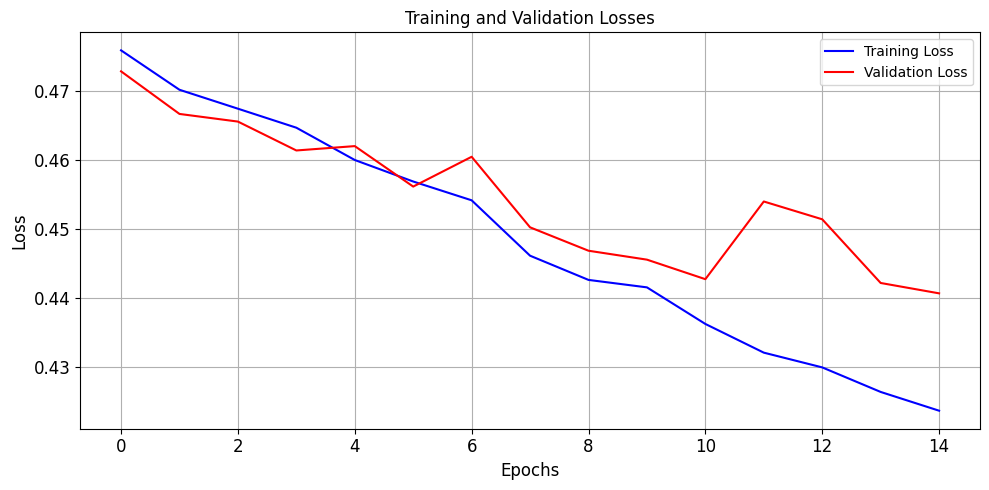

              precision    recall  f1-score   support

    Not Hate       0.94      1.00      0.97      5945
        Hate       0.80      0.23      0.35       448

    accuracy                           0.94      6393
   macro avg       0.87      0.61      0.66      6393
weighted avg       0.93      0.94      0.93      6393



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import classification_report
import copy
import matplotlib.pyplot as plt

X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)

y_train_tensor = torch.tensor(np.eye(2)[y_train.values], dtype=torch.float32)  
y_test_tensor = torch.tensor(np.eye(2)[y_test.values], dtype=torch.float32)  

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, max_len):
        super(BiLSTMModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False  

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output dimension is 2 (logits for both classes)
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)  
        lstm_out, _ = self.lstm(embedded) 
        lstm_out = lstm_out[:, -1, :] 
        out = self.dropout(lstm_out) 
        out = self.fc(out)  
        out = self.relu(out)  
        return out

# Hyperparameters
hidden_dim = 128  
output_dim = 2  
vocab_size = len(word_index) + 1 
embedding_dim = 300  
embedding_matrix = np.random.rand(vocab_size, embedding_dim) 
max_sequence_length = 100  

# Initialize the model
model = BiLSTMModel(vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, max_sequence_length)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

# Early Stopping 
patience = 5  
min_delta = 0.001  
best_val_loss = float('inf')
counter = 0
best_model_state = None

# Tracking losses for plotting
train_losses = []
val_losses = []

num_epochs = 15
for epoch in range(num_epochs):
    model.train()  
    running_train_loss = 0.0
    
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()  

        outputs = model(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step() 

        running_train_loss += loss.item()

    model.eval()  
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(test_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        counter = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        counter += 1
    
    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state")

# Plot Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.eval()  

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        
        predictions = torch.argmax(torch.sigmoid(outputs), dim=1)  
        
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())  

print(classification_report(all_labels, all_preds, target_names=['Not Hate', 'Hate']))

In [91]:
import torch
import pickle

# torch.save(model.state_dict(), "lstm_model.pth")

with open("bi_lstm_model_glove.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved successfully!")

Model saved successfully!
